# Lab 10: Generative AI - Generative Adversarial Networks (GANs)

Objectives:
1.  **GAN Theory:** An intuitive explanation of how Generative Adversarial Networks work.
2.  **Implementation:** Building a simple GAN from scratch using PyTorch to generate images of handwritten digits (MNIST dataset).
3. Recognize common GAN failure modes: **mode collapse**, **discriminator overpowering the generator**, and **vanishing gradients for the generator**.

## 1. Theory of Generative Adversarial Networks (GANs)

GANs are a clever type of generative model introduced by Ian Goodfellow and his colleagues in 2014. The core idea is to have two neural networks compete against each other in a zero-sum game. This competition drives both networks to improve until the model can generate new, realistic data.

The two networks are:

1.  **The Generator (G):** Its job is to create fake data. It takes a random noise vector (called a latent vector) as input and tries to transform it into something that looks like the real data (e.g., an image of a handwritten digit).

2.  **The Discriminator (D):** Its job is to be a detective. It takes in data (both real samples from the training set and fake samples from the Generator) and must determine whether the data is real or fake. It outputs a probability between 0 (definitely fake) and 1 (definitely real).

### The Adversarial Game

Think of the Generator as an art forger trying to create counterfeit paintings, and the Discriminator as an art critic trying to identify them.

*   Initially, the forger (Generator) is terrible and produces random scribbles. The critic (Discriminator) can easily tell the fakes from the real paintings.
*   The forger gets feedback from the critic's decisions and learns to improve its forgeries to better fool the critic.
*   As the forger gets better, the critic must also get better at spotting the increasingly sophisticated fakes.

This process repeats. The Generator's goal is to **maximize** the final error (fool the Discriminator), while the Discriminator's goal is to **minimize** the final error. They are trained in an alternating fashion. By the end of the training, the Generator becomes so good that the Discriminator is only about 50% accurate, meaning it can no longer distinguish real from fake. At this point, the Generator can produce highly realistic, novel data.

![GAN Architecture](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQhpV1m2IAZRcvdwkhVak3MpWEeWVrpArLxtA&s)

## 2. Implementation: A Simple GAN for MNIST

In [5]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [6]:
import os, certifi

os.environ["SSL_CERT_FILE"] = certifi.where()
os.environ["REQUESTS_CA_BUNDLE"] = os.environ["SSL_CERT_FILE"]

### 2.1 Hyperparameters and Data Loading

In [7]:
# Baseline hyperparameters
latent_dim = 64
hidden_dim = 256
image_size = 28 * 28  # MNIST flattened
batch_size = 128
lr_g = 2e-4
lr_d = 2e-4

beta1, beta2 = 0.5, 0.999
num_epochs = 30

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

len(train_dataset), len(train_loader)

100%|██████████| 9.91M/9.91M [00:07<00:00, 1.27MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 175kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 991kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.25MB/s]


(60000, 468)

### 2.2 Building the Generator and Discriminator

- **Generator**: noise (latent_dim) → fully connected layers → 784-dim vector → reshaped into 28×28 image.
- **Discriminator**: 784-dim vector → fully connected layers → scalar probability via Sigmoid.

This is not state-of-the-art (DCGAN with convolutions performs better), but it is easy to understand.

You may use LeakyReLU as an activation function for in between layers and Tanh to get the output in [-1,1] interval


In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim=64, hidden_dim=256, img_dim=784):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim * 2, img_dim),
            nn.Tanh(),  # output in [-1, 1]
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    def __init__(self, img_dim=784, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid(),  # probability real (1) vs fake (0)
        )

    def forward(self, x):
        return self.net(x)

### 2.3 Initializing Models, Loss, and Optimizers

In [10]:
G = Generator(latent_dim=latent_dim, hidden_dim=hidden_dim, img_dim=image_size).to(device)
D = Discriminator(img_dim=image_size, hidden_dim=hidden_dim).to(device)

criterion = nn.BCELoss()

optimizer_G = optim.Adam(
    G.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

optimizer_D = optim.Adam(
    D.parameters(),
    lr=2e-4,
    betas=(0.5, 0.999)
)

In [11]:
#Visualizing generated samples helper
def show_fake_samples(epoch, fixed_noise, nrow=8):
    G.eval()
    with torch.no_grad():
        fake = G(fixed_noise.to(device)).view(-1, 1, 28, 28)
    G.train()
    fake = (fake + 1) / 2.0  # back to [0, 1] for display
    grid = utils.make_grid(fake, nrow=nrow)
    plt.figure(figsize=(6, 6))
    plt.title(f"Generated samples at epoch {epoch}")
    plt.axis('off')
    plt.imshow(grid.cpu().permute(1, 2, 0).squeeze())
    plt.show()


fixed_noise = torch.randn(64, latent_dim, device=device)

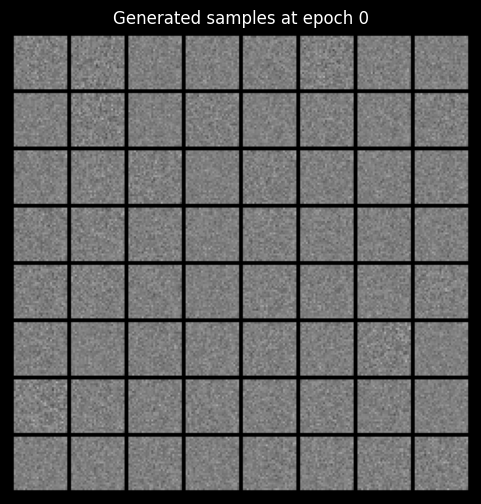

In [12]:
show_fake_samples(0, fixed_noise)

### 2.4 The Training Loop
We first train a **baseline GAN** with reasonably stable hyperparameters.  
After that, we will **intentionally break** the training in different ways to illustrate:

- **Mode collapse**
- **Discriminator overpowering the Generator**
- **Vanishing gradients for the Generator**

Epoch [1/30]  D_loss: 0.9643  G_loss: 1.4415


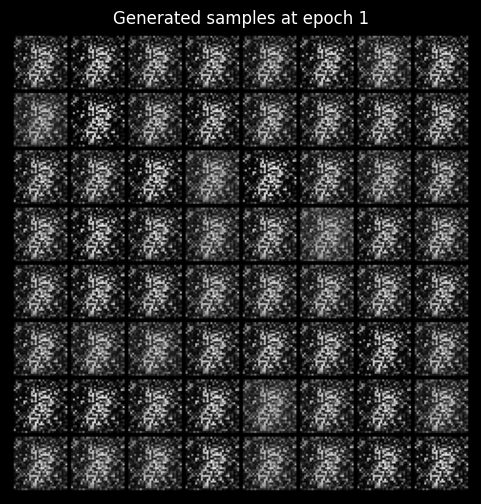

Epoch [2/30]  D_loss: 1.2160  G_loss: 3.0465


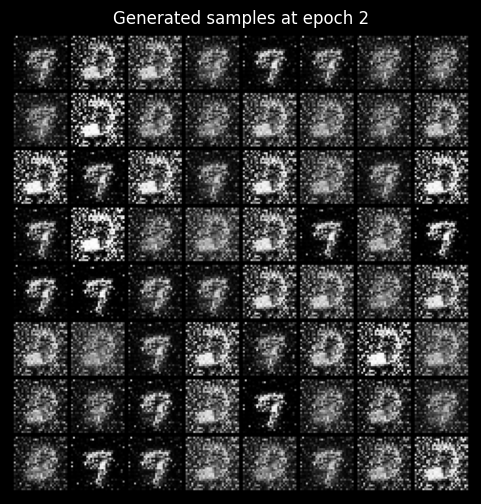

Epoch [3/30]  D_loss: 0.9766  G_loss: 1.5106


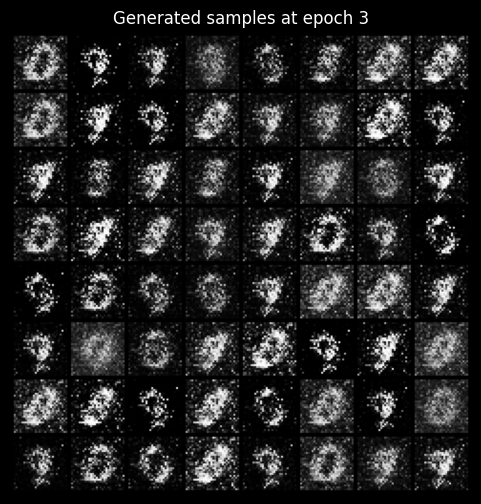

Epoch [4/30]  D_loss: 1.1402  G_loss: 0.8564


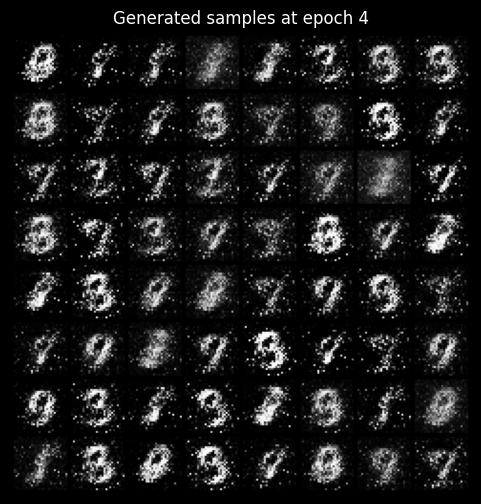

Epoch [5/30]  D_loss: 0.7821  G_loss: 1.7966


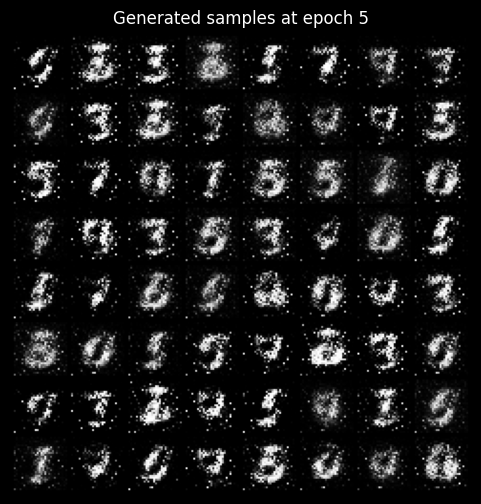

Epoch [6/30]  D_loss: 0.6572  G_loss: 1.7152


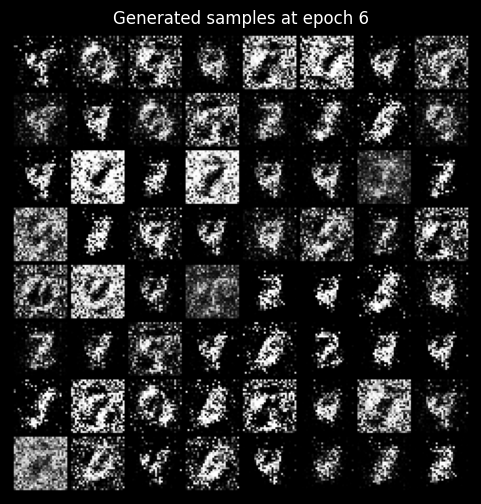

Epoch [7/30]  D_loss: 0.6965  G_loss: 1.8542


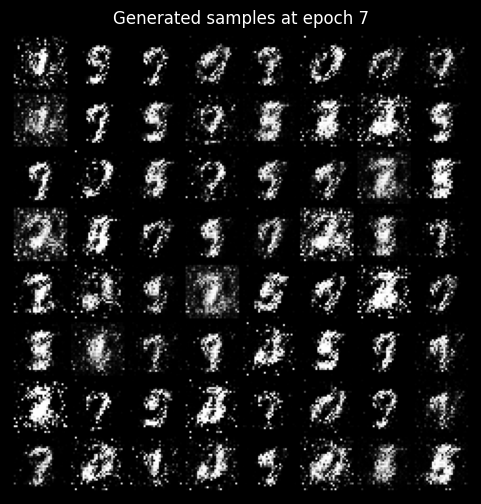

Epoch [8/30]  D_loss: 0.9490  G_loss: 2.6430


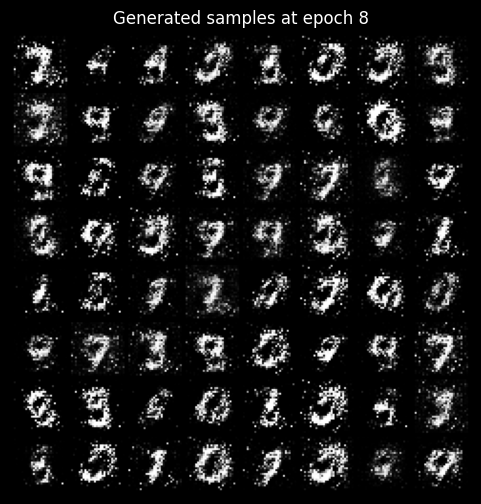

Epoch [9/30]  D_loss: 0.6286  G_loss: 2.5384


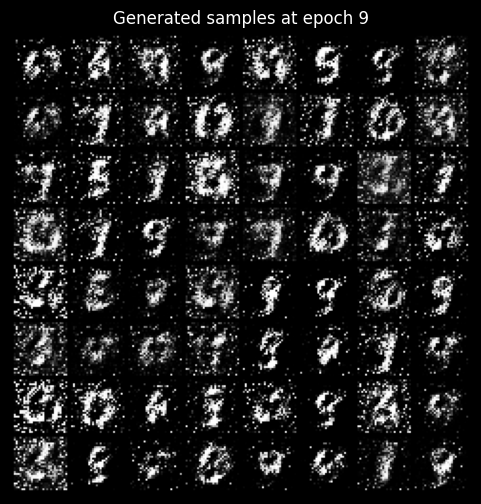

Epoch [10/30]  D_loss: 0.5839  G_loss: 2.9879


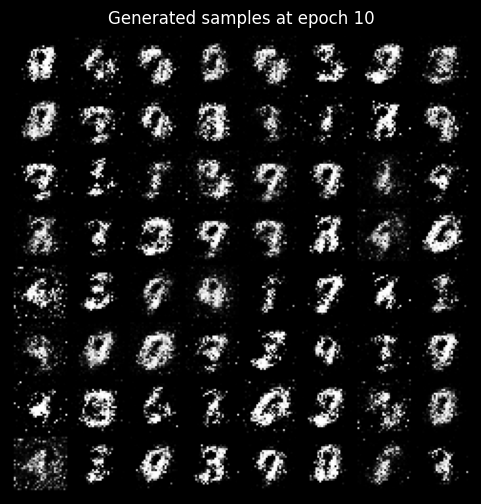

Epoch [11/30]  D_loss: 0.8985  G_loss: 1.1670


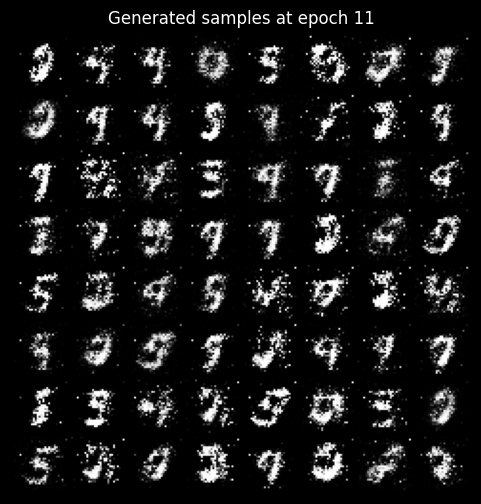

Epoch [12/30]  D_loss: 0.6971  G_loss: 1.3849


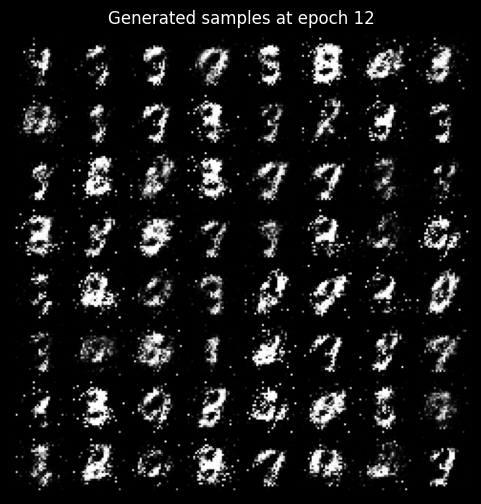

Epoch [13/30]  D_loss: 0.7794  G_loss: 3.1427


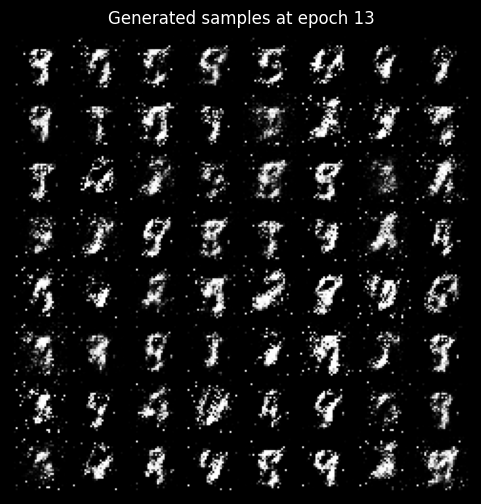

Epoch [14/30]  D_loss: 0.5987  G_loss: 3.6110


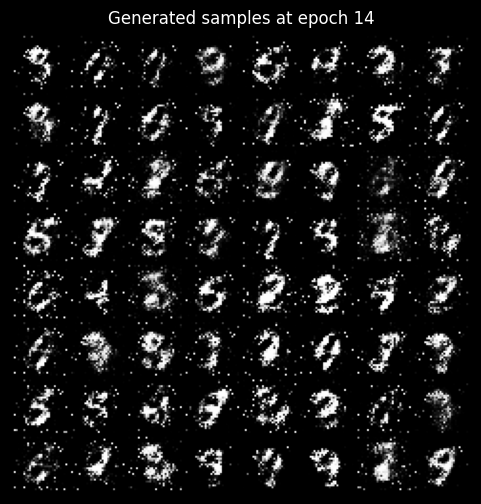

Epoch [15/30]  D_loss: 0.5884  G_loss: 1.9778


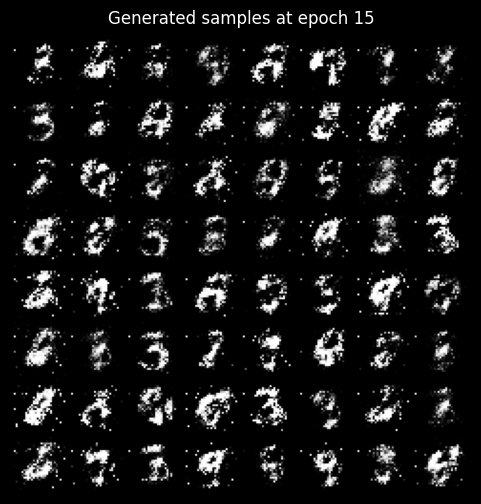

Epoch [16/30]  D_loss: 0.5448  G_loss: 1.8298


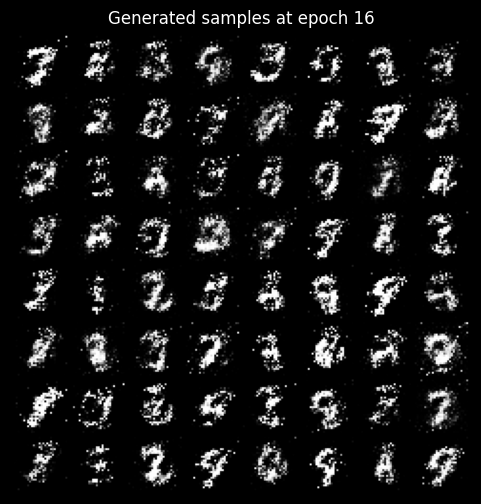

Epoch [17/30]  D_loss: 0.7245  G_loss: 1.6354


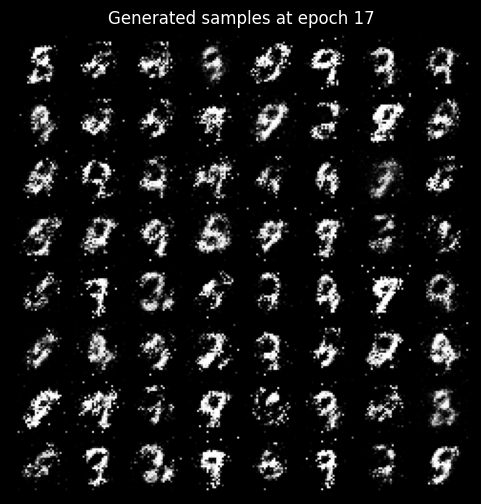

Epoch [18/30]  D_loss: 0.8730  G_loss: 1.1923


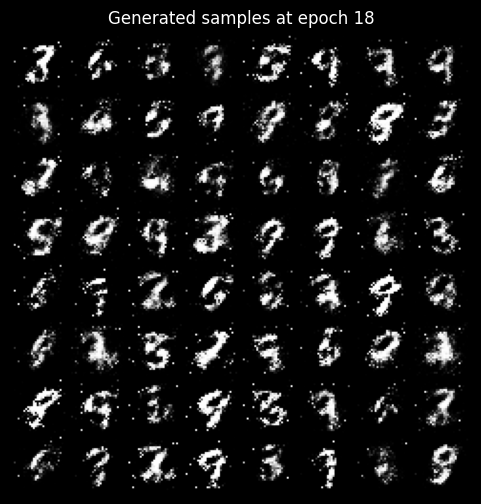

Epoch [19/30]  D_loss: 0.8075  G_loss: 1.4565


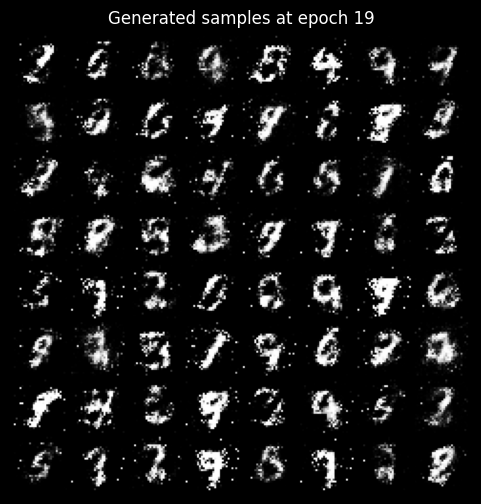

Epoch [20/30]  D_loss: 0.8320  G_loss: 1.9531


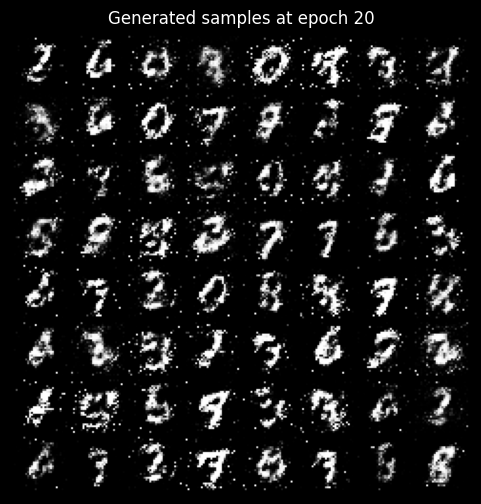

Epoch [21/30]  D_loss: 0.8602  G_loss: 1.3183


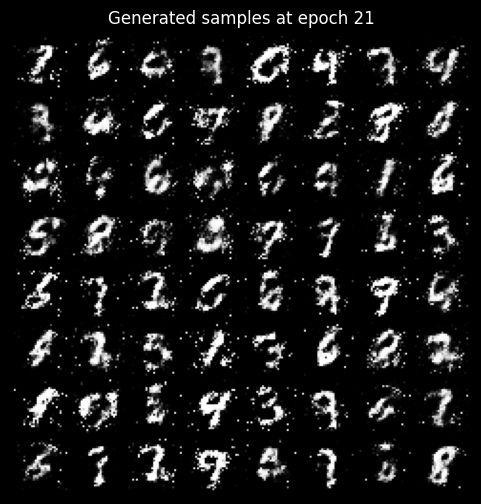

Epoch [22/30]  D_loss: 1.0254  G_loss: 1.2064


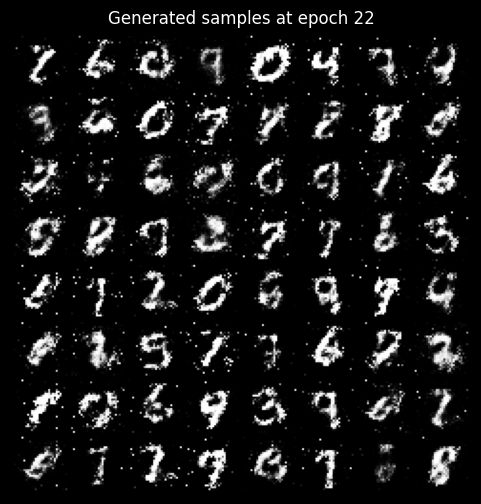

Epoch [23/30]  D_loss: 1.0322  G_loss: 1.0367


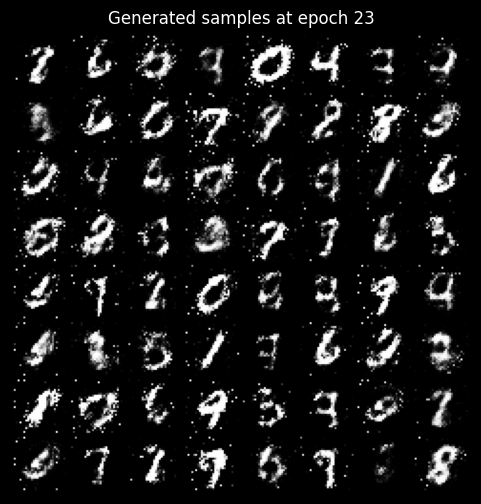

Epoch [24/30]  D_loss: 1.0053  G_loss: 1.0188


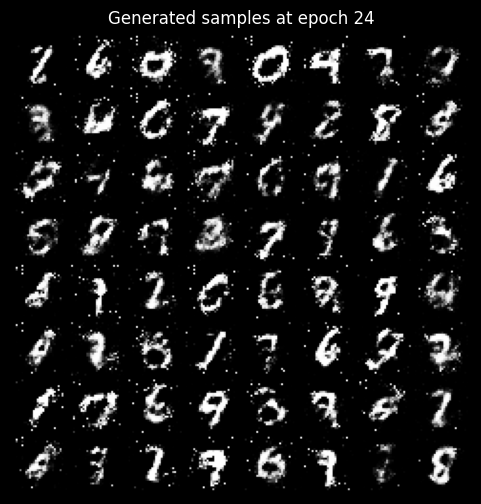

Epoch [25/30]  D_loss: 0.9873  G_loss: 1.0363


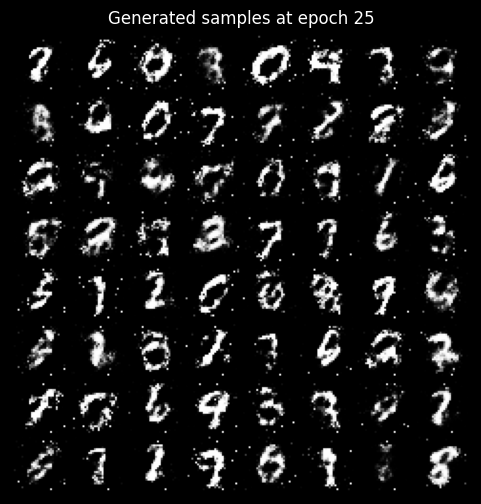

Epoch [26/30]  D_loss: 1.0308  G_loss: 1.1102


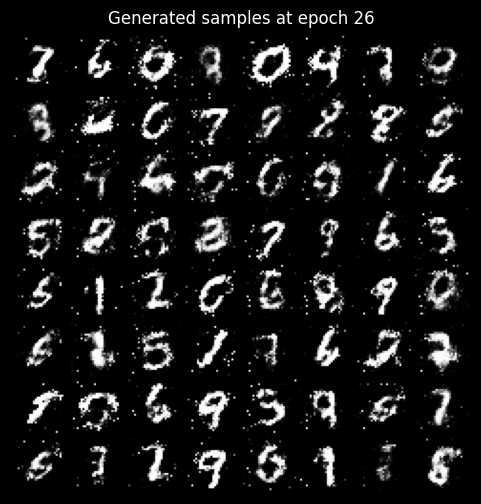

Epoch [27/30]  D_loss: 0.8871  G_loss: 1.4466


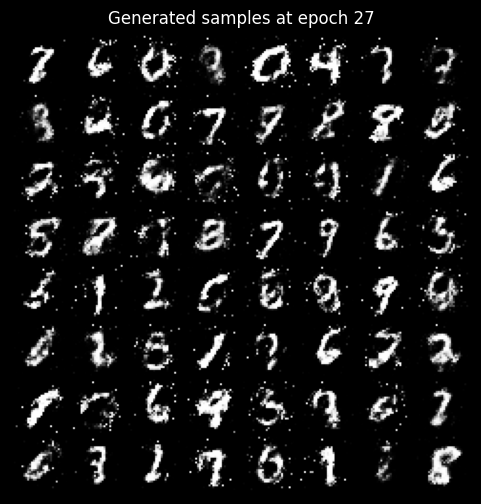

Epoch [28/30]  D_loss: 1.2088  G_loss: 0.5980


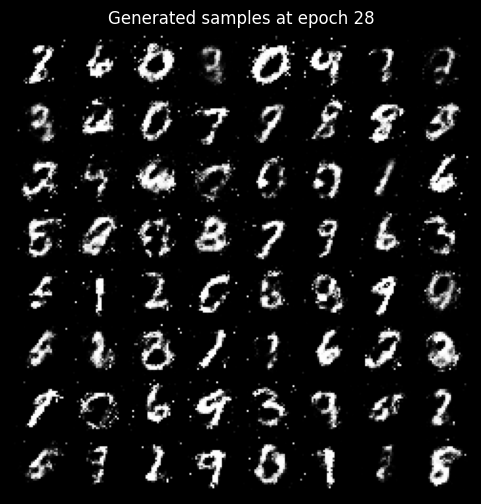

Epoch [29/30]  D_loss: 1.1853  G_loss: 0.9336


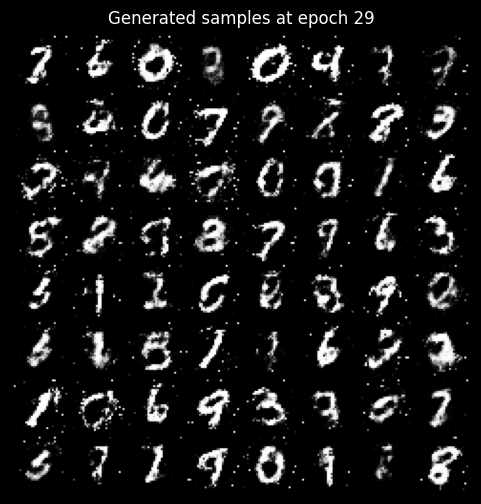

Epoch [30/30]  D_loss: 1.0936  G_loss: 0.7908


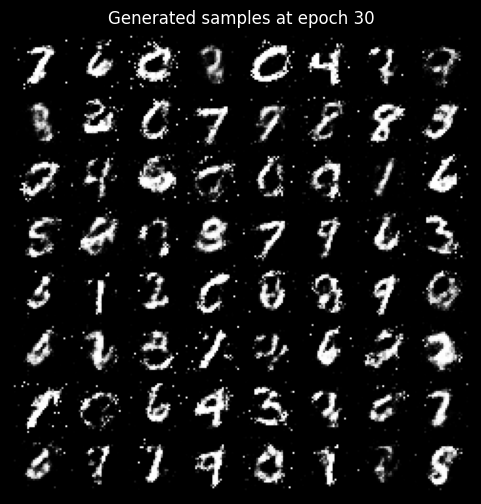

In [13]:
G.train()
D.train()

g_losses = []
d_losses = []

for epoch in range(1, num_epochs + 1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.view(-1, image_size).to(device)

        # --------------------
        #  Train Discriminator
        # --------------------
        optimizer_D.zero_grad()

        # Prepare real and fake labels for future train
        real_labels = torch.ones(real_imgs.size(0), 1, device=device) # array of 1s for the selected images
        fake_labels = torch.zeros(real_imgs.size(0), 1, device=device) # array of 0s for the to-be-generated images

        outputs_real = D(real_imgs)
        d_loss_real = criterion(outputs_real, real_labels)

        # Fake images
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z) # generate from noise
        outputs_fake = D(fake_imgs) # what does the discriminator think?
        d_loss_fake = criterion(outputs_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ----------------
        #  Train Generator
        # ----------------
        optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(z)
        outputs = D(fake_imgs)
        # Generator wants D to think fakes are real (label = 1)
        g_loss = criterion(outputs, real_labels)

        # backward and steps...
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

    # clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")
    show_fake_samples(epoch, fixed_noise)

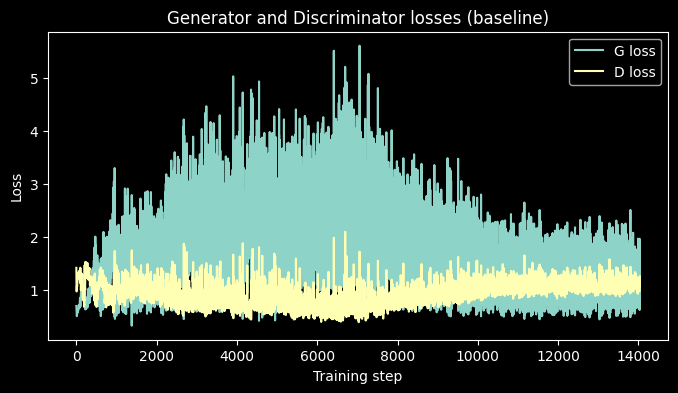

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(g_losses, label='G loss')
plt.plot(d_losses, label='D loss')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.title('Generator and Discriminator losses (baseline)')
plt.legend()
plt.show()

Let's move the above in a function so we can see how it behaves with different hyperparams

In [15]:
def train_gan(G, D, optimizer_G, optimizer_D, train_loader,
              latent_dim, num_epochs,
              experiment_name : str,
              train_D_twice=False):
  G.train()
  D.train()

  g_losses = []
  d_losses = []

  fixed_noise = torch.randn(64, latent_dim, device=device)


  for epoch in range(1, num_epochs + 1):
      for real_imgs, _ in train_loader:
          real_imgs = real_imgs.view(-1, image_size).to(device)

          # --------------------
          #  Train Discriminator
          # --------------------
          # For enhancing the misbalance that can happen with a discriminator
          # that is too good, we allow it to train multiple times
          d_steps = 1 if train_D_twice == False else 2
          for _ in range(d_steps):
            optimizer_D.zero_grad()

            real_labels = torch.ones(real_imgs.size(0), 1, device=device)
            fake_labels = torch.zeros(real_imgs.size(0), 1, device=device)

            # Real images
            outputs_real = D(real_imgs)
            d_loss_real = criterion(outputs_real, real_labels)

            # Fake images
            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            fake_imgs = G(z).detach()   # detach so G is not updated here
            outputs_fake = D(fake_imgs)
            d_loss_fake = criterion(outputs_fake, fake_labels)

            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

          # ----------------
          #  Train Generator
          # ----------------

          optimizer_G.zero_grad()

          # fresh noise
          z = torch.randn(real_imgs.size(0), latent_dim, device=device)

          # generate fakes (NO detach here)
          fake_imgs = G(z)

          # discriminator output on fakes
          outputs = D(fake_imgs)

          # Generator wants D to think fakes are real (label = 1)
          g_loss = criterion(outputs, real_labels)

          # optimizers, steps...
          g_loss.backward()
          optimizer_G.step()

          g_losses.append(g_loss.item())
          d_losses.append(d_loss.item())

      print(
            f"Mode: {experiment_name} | Epoch [{epoch}/{num_epochs}] "
            f"D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}"
      )
      show_fake_samples(epoch, fixed_noise, nrow=8)

## 6. Failure Mode Showcase: Breaking the GAN on Purpose

In this section, we **intentionally misconfigure** the GAN to demonstrate three classic failure modes:

1. **Mode collapse** - the Generator produces very similar or identical samples.
2. **Discriminator overpowered by the Generator/Generator overpowering Discriminator**
3. **Vanishing gradients for the Generator** - G's gradients go to ~0, training stalls.



### Mode Collapse

### Discriminator overpowering the Generator
